image.png

# Part III: Forecasting

Wellcome to the third guided lesson of 'Deep Learning para Series Temporales' del 'Máster en Deep Learning' by UPM. This notebook will introduce you to various forecasting models, from classical methods like ARIMA to advanced deep learning models like the Moment family.

Throughout this notebook, you’ll find basic code implementations that will allow you to know more about those models and apply them into your own data for predicting future values based on past ones.

⏩ *Let's start!* ⏩

## Install dependencies

In [ ]:
#! pip install aeon
#! pip install "pydantic<2" --force-reinstall
#! pip install pandas_profiling
#! pip install tslearn

#!pip install numpy pandas matplotlib tqdm
#!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git
#! pip install datasets
#--- pdf
#! pip install pypandoc
#! pip install pandoc
#! pip install pypandoc
#! apt-get install pandoc
#! apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc texlive-latex-extra
  context wkhtmltopdf librsvg2-bin groff ghc nodejs php python ruby libjs-mathjax libjs-katex
  citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB]


## Build an example time series

To begin, we will create a synthetic time series using the classical additive decomposition. [You can fell free of changing this implementation by using the introduction notebook implementations you did!]

This data will be our baseline for testing the different forecasting methods.

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [ ]:
# Set the random seed for reproducibility
np.random.seed(0)

# Define the parameters
n_samples = 1000  # Number of samples in the time series
seasonality_period = 12  # Period of the cosine seasonality
noise_std = 0.2  # Standard deviation of the noise

# Generate the time index
t = np.arange(n_samples)

# Generate the cosine seasonality component
seasonality = np.cos(2 * np.pi * t / seasonality_period)

# Generate the noise component
noise = np.random.normal(0, noise_std, n_samples)

# Combine the components to create the synthetic time series
time_series = seasonality + noise

### Plot the time series

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot( time_series,  label='Time series')

#plt.axvspan(0, split_index, color='lightcoral', alpha=0.5)
#plt.axvspan(split_index, n_samples, color='lightgreen', alpha=0.5)

plt.title('Train-Test Split of Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

### Split into train and test datasets

Now we got the data, we must divide it into train and test dataset. Why?

> We predict the future values based on past ones, the most *similar* the best we are doing.

- Train dataset: is given to the model so he can "learn" the shape of our time series.
- Test dataset: using the historical (train) data we make the model predict the values for the test dataset (future) and then check how similar the prediction is to the original testing data.

In [ ]:
# Define the train-test split ratio
train_ratio = 0.8

# Calculate the index to split the time series
split_index = int(len(time_series) * train_ratio)

# Split the time series into train and test sets
train_set = time_series[:split_index]
test_set = time_series[split_index:]

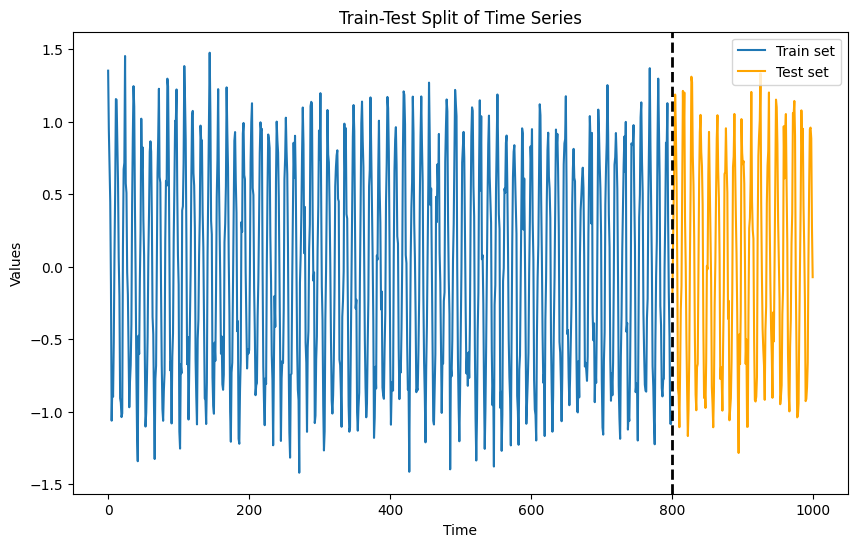

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(0, split_index), time_series[:split_index],  label='Train set')
plt.plot(range(split_index, n_samples), time_series[split_index:], color='orange', label='Test set')

#plt.axvspan(0, split_index, color='lightcoral', alpha=0.5)
#plt.axvspan(split_index, n_samples, color='lightgreen', alpha=0.5)
plt.axvline(x=split_index, color='black', linestyle='--', linewidth=2)

plt.title('Train-Test Split of Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

### Save as DataFrame

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_set, columns=["value"])
test_df = pd.DataFrame(test_set, columns=["value"])

## Utilities

The following utilities will help us calculate errors like RMSE, MAE, and DTW, and visualize predictions against ground truth values.

> These are distance metrics that will allow us to check the similarity between the predicted values and the test dataset one. You will see that they my "focus on different charasteristics of the time series", telling you different kind of 'similarity'. One of the first steps in training or evaluating a model is to decide the metric depending on your time series shape and how will it go.



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tslearn.metrics import dtw
from scipy.spatial.distance import euclidean

In [ ]:
def plot_and_validate(train, test, predictions):
    errors = pd.DataFrame(columns=['Feature', 'RMSE', 'RMSE %', 'MAE', 'MAE %', 'DTW', 'DTW %'])

    if len(test.columns) > 1:
        test_values = test.values
        for i, column in enumerate(test.columns):
            range = np.max(test[column])-np.min(test[column])
            rmse = np.sqrt(mean_squared_error(test[column], predictions[:, i]))
            rmse_pcnt = rmse / range * 100
            mae = mean_absolute_error(test[column], predictions[:, i])
            mae_pcnt = mae / range * 100
            dtw_ = dtw(test[column].values.flatten(), predictions[:, i].flatten())
            dtw_pcnt = dtw_ / range * 100
            # Use pd.concat to append a new row to the DataFrame
            new_row = pd.DataFrame({'Feature': [column], 'RMSE': [rmse], 'RMSE %': [rmse_pcnt],
                                    'MAE': [mae], 'MAE %': [mae_pcnt], 'DTW': [dtw_], 'DTW %': [dtw_pcnt]})
            if i == 0:
              errors = new_row
            else:
              errors = pd.concat([errors, new_row], ignore_index=True)
    else:
        test_values = test.iloc[:, 0].values.flatten()  # Ensure it's 1D
        predictions = np.array(predictions).flatten()  # Convert list to 1D array
        range = np.max(test_values)-np.min(test_values)
        rmse = np.sqrt(mean_squared_error(test_values, predictions))
        rmse_pcnt = rmse *100/range
        mae = mean_absolute_error(test_values, predictions)
        mae_pcnt = mae *100/range
        dtw_ = dtw(test_values, predictions)  # Now 1D
        dtw_pcnt = dtw_ *100/ range
        # Use pd.concat to append a new row to the DataFrame
        new_row = pd.DataFrame({'Feature': ['Value'], 'RMSE': [rmse], 'RMSE %': [rmse_pcnt],
                                'MAE': [mae], 'MAE %': [mae_pcnt], 'DTW': [dtw_], 'DTW %': [dtw_pcnt]})
        errors = new_row

    plt.figure(figsize=(18,6))
    # Plot train set
    plt.plot(train, label='Train Set')

    # Plot test set
    test_x = np.arange(len(train), len(train)+len(test))
    plt.plot(test_x, test_values, label='Test Set')
    plt.plot(test_x, predictions, label='Predictions')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.show()

    return errors, plt

## Forecast using persistence

**Persistence** assumes that the next value in the series is the same as the last observed value. It's a naive method but provides a useful baseline.

**Real-World Example:** You can baseline forecasts for product demand before applying more sophisticated methods. Source: [Research paper: Persistence modeling for sales prediction: A simple, self-contained approach](https://www.sciencedirect.com/science/article/abs/pii/[S0148296323004617).
[Authors' LinkedIn Post](https://www.linkedin.com/posts/paolo-antonetti-6829553_persistence-modeling-for-sales-prediction-activity-7076842890336825344-1mi1).

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#### Basic example
This is a basic example of days and prices, where 'prices' show the price of a product in the specific day. We will use it in some algorithms for taking a first look.

In [ ]:
df_basic = pd.DataFrame(columns = ['day', 'value'])
df_basic ['day']           = [0, 1,2,3,4,5,6,7,8]
df_basic ['value']        = [10,12,9,10,15,13,18, 18,20]
df_basic = df_basic.copy().set_index('day')
display(df_basic.T)

day     0   1  2   3   4   5   6   7   8
value  10  12  9  10  15  13  18  18  20

In [ ]:
forecast_horizon = 5
df_pers = df_basic.copy()
new_rows = pd.DataFrame({
    'value': [np.nan] * forecast_horizon,
    f'predict': [np.nan] * forecast_horizon
    }
)
df_pers = pd.concat([df_pers, new_rows], ignore_index = True)
df_pers[f'predict'] =  df_pers['value'].shift(forecast_horizon)
display(df_pers.T)

0     1    2     3     4     5     6     7     8     9     10  \
value    10.0  12.0  9.0  10.0  15.0  13.0  18.0  18.0  20.0   NaN   NaN   
predict   NaN   NaN  NaN   NaN   NaN  10.0  12.0   9.0  10.0  15.0  13.0   

           11    12    13  
value     NaN   NaN   NaN  
predict  18.0  18.0  20.0

#### Back to Initial Example

In [ ]:
forecast_horizon = 20
values = train_df.values

forecast_time = np.arange(len(train_df), len(train_df)+len(test_df), 1)
forecast_values = test_df.values.copy()
for t in range(len(forecast_time)):
  val = t-forecast_horizon+len(train_df)+1
  #print(f"Checking {val} | {len(train_df)}")
  if val > len(train_df)-2:
    #print("Using predictions")
    val = val - len(train_df)+1
    #print(f"New val = {val}")
    forecast_values[t] = forecast_values[val]
  else:
    #print("Using known dataset")
    forecast_values[t] = train_df.values[val]

Test RMSE: 1.075


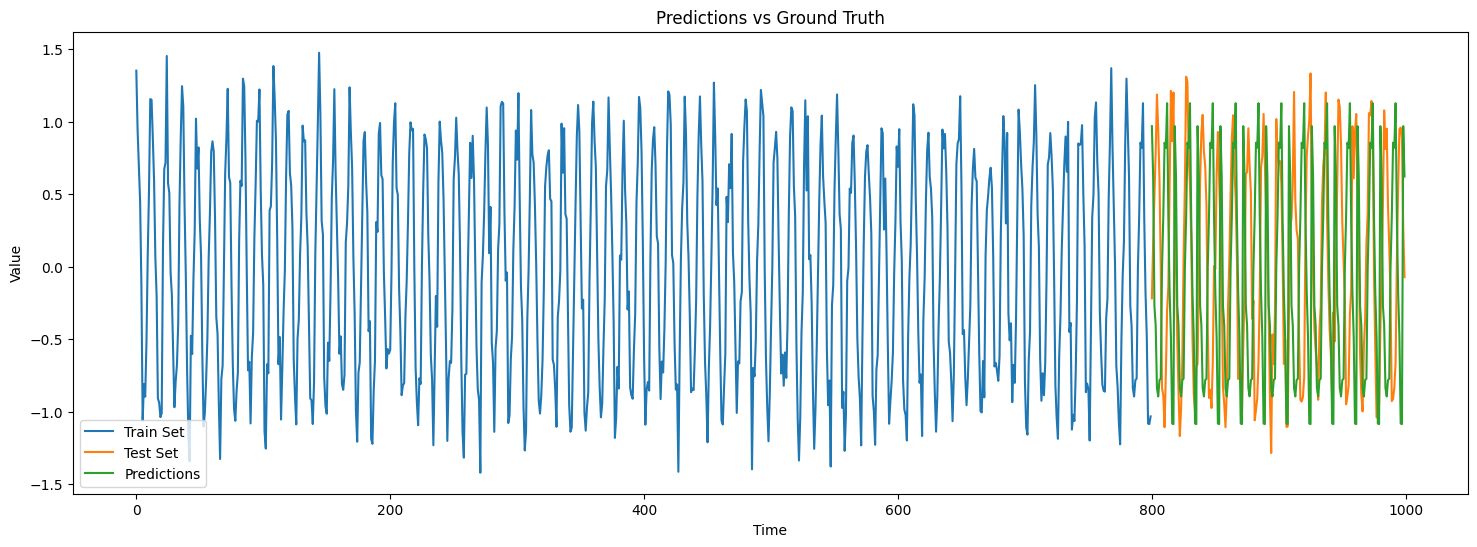

Feature      RMSE     RMSE %       MAE      MAE %       DTW       DTW %
0   Value  1.075292  41.067772  0.871813  33.296484  5.939623  226.847402

In [ ]:
rmse = np.sqrt(mean_squared_error(test_df.values, forecast_values))
print('Test RMSE: %.3f' % rmse)

# Plot train set
errors, plot = plot_and_validate(train_df, test_df, forecast_values)
display(errors)

## Forecast using SMA

### Basic example

Remember the rolling mean? Let's take a look again at how is it computed and how to apply it for prediction.

In [ ]:
from IPython.display import display, clear_output
import time

In [ ]:
df_basic = pd.DataFrame(columns = ['day', 'prices'])
df_basic['day']           = [0, 1,2,3,4,5,6,7,8]
df_basic['prices']        = [10,12,9,10,15,13,18, 18,20]
df_basic = df_basic.copy().set_index('day')
display(df_basic)

prices
day        
0        10
1        12
2         9
3        10
4        15
5        13
6        18
7        18
8        20

This is how the rolling mean is computed for window = 2. Try to think the next value before it appears in the print.

In [ ]:
# Option 1
df_sma_1 = df_basic.copy()
df_sma_1['SMA_2'] = np.nan
for i in np.arange(1, df_sma_1.shape[0]):
    clear_output(wait=True)
    print(f"Rolling mean pos {i}")
    df_sma_1.loc[i,'SMA_2'] = (df_sma_1['prices'][i-1]+df_sma_1['prices'][i])/2
    display(df_sma_1.T)
    time.sleep(2)

Rolling mean pos 8


day        0     1     2     3     4     5     6     7     8
prices  10.0  12.0   9.0  10.0  15.0  13.0  18.0  18.0  20.0
SMA_2    NaN  11.0  10.5   9.5  12.5  14.0  15.5  18.0  19.0

In [ ]:
# Option 2
df_sma_2 = df_basic.copy()
df_sma_2['SMA_2'] = np.nan*(df_sma_2.shape[0]+1)
# df_sma_1 = pd.concat([df_sma_1, pd.DataFrame({'prices': [np.nan]})], ignore_index=True)
for i in np.arange(2, df_basic.shape[0]+2):
    print(f"Rolling mean {i}")
    df_sma_2['SMA_2'][i] = df_sma_2['prices'][i-1:i+1].mean()
    clear_output(wait=True)
    display(df_sma_2)
    time.sleep(2)

prices  SMA_2
day               
0        10    NaN
1        12    NaN
2         9   10.5
3        10    9.5
4        15   12.5
5        13   14.0
6        18   15.5
7        18   18.0
8        20   19.0

In [ ]:
# Option 3: Direct
df_sma_3 = df_basic.copy()
df_sma_3['SMA_2'] = df_sma_3['prices'].rolling(window=2).mean()
display(df_sma_3)

prices  SMA_2
day               
0        10    NaN
1        12   11.0
2         9   10.5
3        10    9.5
4        15   12.5
5        13   14.0
6        18   15.5
7        18   18.0
8        20   19.0

And how do we predict using SMA?
Remember we have:
- **Historical data**: already known/predicted values
- **Forecasted data**: predicted values
For the forecasted data we usually have:
- **Lookback**: length of the historical data used for predicting the next value
- **Horizon**: the position/the length of the predicted value(s)

SMA goes one by one. In this case:
- **Lookback**: window we use for the rolling mean.
- **Horizon**: how much do we shift the vakyes so that (t, ..., t-L) is used to predict t+H.

In [ ]:
forecast_horizon = 3
lookback = 2
df_sma_4 = df_basic.copy()
if forecast_horizon > 0 and lookback > 0:
  history = df_sma_4.shape[0]
  new_rows = pd.DataFrame({
      'prices': [np.nan] * forecast_horizon,
      f'RollingMean_{lookback}': [np.nan] * forecast_horizon
      }
  )
  df_sma_4 = pd.concat([df_sma_4, new_rows], ignore_index = True)
  df_sma_4[f'predict_L{lookback}_H{forecast_horizon}'] =  np.nan
  df_sma_4[f'RollingMean_{lookback}'] = df_sma_4['prices'].rolling(window = lookback).mean()
  prediction = df_sma_4[f'RollingMean_{lookback}'].shift(forecast_horizon)
  for r in range(history, history+forecast_horizon):
    last_values = prediction[r-lookback-1:r-1]
    if (last_values.notna().all()):
      prediction.iloc[r]=last_values.mean()
  df_sma_4[f'predict_L{lookback}_H{forecast_horizon}'] = prediction
  prediction = prediction[history:]
  #df_sma.loc[history:, 'predict_k'] = prediction
  #df_sma.loc[range(history), 'predict_k'] = np.nan
  display(df_sma_4.T)

0     1     2     3     4     5     6     7     8     9   \
prices         10.0  12.0   9.0  10.0  15.0  13.0  18.0  18.0  20.0   NaN   
RollingMean_2   NaN  11.0  10.5   9.5  12.5  14.0  15.5  18.0  19.0   NaN   
predict_L2_H3   NaN   NaN   NaN   NaN  11.0  10.5   9.5  12.5  14.0  11.0   

                  10    11  
prices           NaN   NaN  
RollingMean_2    NaN   NaN  
predict_L2_H3  13.25  12.5

### Back to the initial example

Now, we are going to apply SMA to check how well does it predicts values of the original example data.

The first step is to define the model function: given the past values (history), the loockback (window size) and the forecast horizont, return the predicted values.

In [ ]:
# Simple Moving Average model considering both lookback (L) and horizon (H)
def model_sma(
    history,      # known data
    window_size,  # Lookback (L)
    forecast_horizon # H
):
    # When predicting f(t+H), we need to go back to f(t-L) and get f(t-L) ... f(t-1)
    # When predicting f(t), wee need to go back to f(t-L-H) and get  f(t-L-H) ... f(t-H)
    w_0 = - (window_size + forecast_horizon)
    w_1 = - forecast_horizon
    return np.mean(history[w_0:w_1])

Now, let's build the forecasting function that will go through test_df predicting the next value.

In [ ]:
def forecast_sma(test_df, forecast_horizon = 1, forecast_lookback = 24):
  # Walk-forward validation for SMA
  predictions_sma = []
  history = train_df['value'].values.tolist()
  for i in range(len(test_df)):
      # Predict f(t+H) using the mean of the last L values before t
      if len(history) >= forecast_lookback + forecast_horizon:
          yhat = model_sma(history, forecast_lookback, forecast_horizon)
      else:
          yhat = np.nan  # Avoid errors at first steps

      predictions_sma.append(yhat)
  return predictions_sma

Now, we can predict & evaluate. You can try to modify the different values and check if any of the distance metric gets better or not.
Does the time series seem to be correctly predicted/modeled? Why?

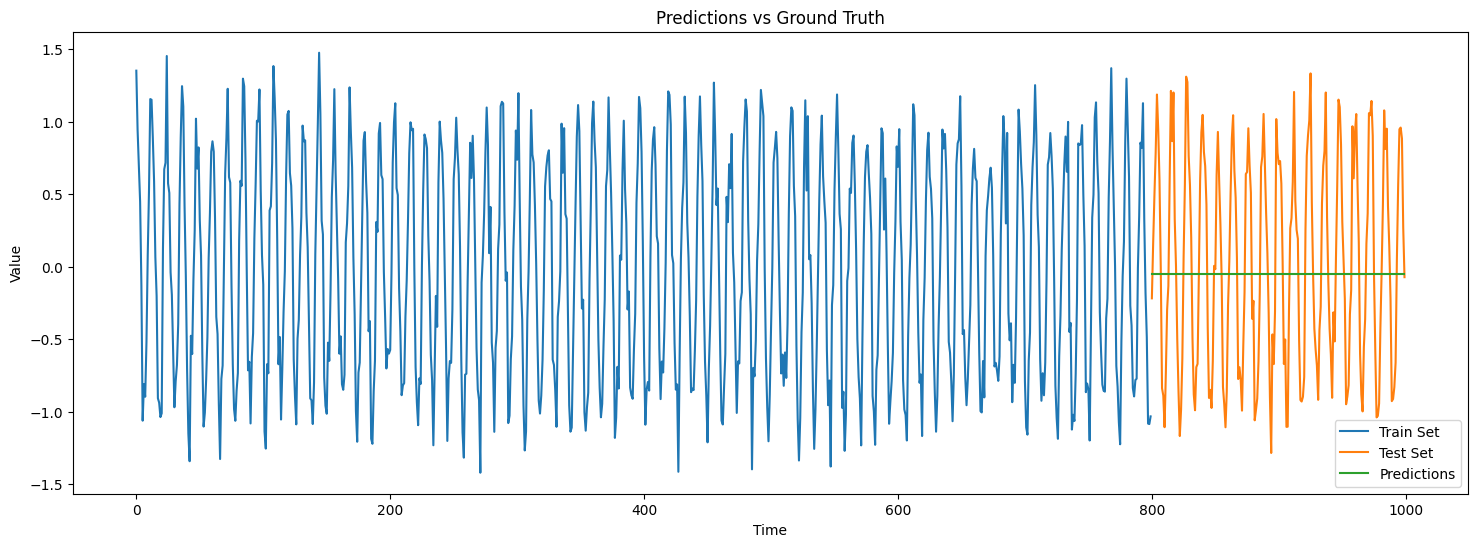

(  Feature      RMSE     RMSE %       MAE     MAE %        DTW       DTW %
 0   Value  0.727931  27.801307  0.640207  24.45094  10.294501  393.169861,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

In [ ]:
predictions_1 = forecast_sma(test_df[['value']], 1, 24)
plot_and_validate(train_df[['value']], test_df[['value']], predictions_1)

## Forecast using Exponential Smoothing

#### Basic example
Let's try the simple example

In [ ]:
df_ets = df_basic.copy()
alpha = 0.2
df_ets[f'ETS_{alpha}'] = np.nan
df_ets[f'ETS_{alpha}'][1] = df_ets['prices'][1]
for i in np.arange(2, df_ets.shape[0]+1):
    df_ets[f'ETS_{alpha}'][i] = alpha*df_ets['prices'][i-1] + (1-alpha)*df_ets[f'ETS_{alpha}'][i-1]
    clear_output(wait=True)
    print(f"{alpha}*{df_ets['prices'][i-1]} + {(1-alpha)}*{df_ets[f'ETS_{alpha}'][i-1]}")
    display(df_ets)
    time.sleep(2)

0.2*20 + 0.8*14.234752000000002


prices    ETS_0.2
day                   
0        10        NaN
1        12  12.000000
2         9  12.000000
3        10  11.400000
4        15  11.120000
5        13  11.896000
6        18  12.116800
7        18  13.293440
8        20  14.234752

 #### Back to the original example

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import numpy as np

def forecast_ets(train_df, test_df, forecast_lookback=None, forecast_horizon=1):
    # Fit the model
    model = SimpleExpSmoothing(train_df['value'])
    model_fit = model.fit(smoothing_level=0.1, optimized=False)

    # Walk-forward validation for Exponential Smoothing
    predictions_exp = []
    history = train_df['value'].values.tolist()

    for i in range(len(test_df) - forecast_horizon+1):
        limited_history = history[-forecast_lookback:]  # Solo usamos `forecast_lookback` datos pasados
        model_fit = SimpleExpSmoothing(limited_history).fit(smoothing_level=0.1, optimized=False)

        # predict f(t+H)
        yhat = model_fit.forecast(forecast_horizon)[-1]
        predictions_exp.append(yhat)

        # Add real observed data to history
        history.append(test_df['value'].iloc[i])
    return predictions_exp

predictions_exp_1 = forecast_ets(train_df, test_df, forecast_lookback=len(train_df), forecast_horizon=1)
predictions_exp_2 = forecast_ets(train_df, test_df, forecast_lookback=2, forecast_horizon=1)

--- Long-Term ---


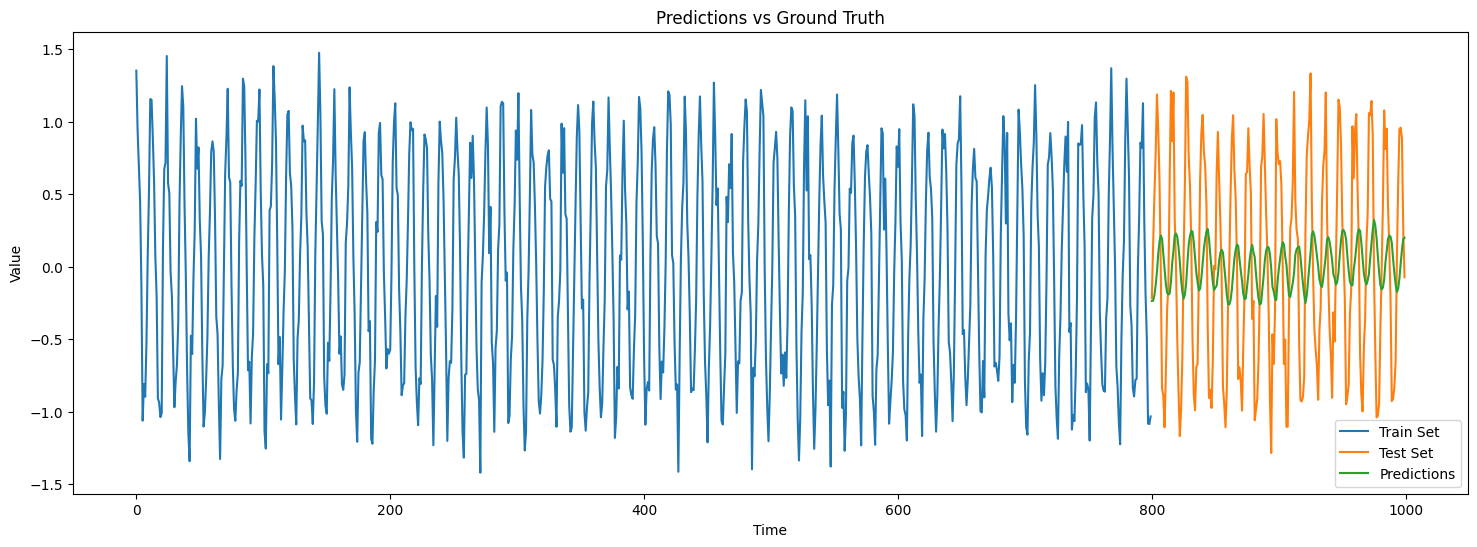

--- Short-Term ---


(  Feature      RMSE     RMSE %       MAE      MAE %       DTW      DTW %
 0   Value  0.717352  27.397276  0.624426  23.848216  1.671387  63.833981,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

In [ ]:
print("--- Long-Term ---")
plot_and_validate(train_df, test_df, predictions_exp_1)
print("--- Short-Term ---")
plot_and_validate(train_df, test_df, predictions_exp_2)

## Forecast using ARIMA & Sarima

In [ ]:
# Import the required libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA model
model_arima = ARIMA(train_df['value'], order=(3,2,10))
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_arima)

# SARIMA model
model_sarima = SARIMAX(train_df['value'], order=(1,0,1), seasonal_order=(1, 1, 0, 12))
model_sarima_fit = model_sarima.fit()

# Make predictions
predictions_sarima = model_sarima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
plot_and_validate(train_df, test_df, predictions_sarima)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(  Feature      RMSE    RMSE %       MAE     MAE %       DTW       DTW %
 0   Value  0.235842  9.007327  0.184831  7.059123  2.771305  105.842271,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

## Models with confidence intervals: Forecast using prophet

In [ ]:
# Import the required library
from prophet import Prophet

### Predict & Check

In [ ]:
print("--- Initialize the model ---")
model_prophet = Prophet(interval_width=0.95)
new_df = train_df.reset_index().rename(columns={'index':'ds', 'value':'y'})
new_df['ds'] = pd.to_datetime(new_df['ds'], unit='M')
print("--- Fit the model ---")
model_prophet.fit(new_df)
print("--- Make future dataFrame ---")
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='M', include_history=False)
print("--- Predict ---")
forecast = model_prophet.predict(future)
print("--- Extract predicted values ---")
predictions_prophet = forecast['yhat'].values[-len(test_df):]
print("--- Plot ---")
plot_and_validate(train_df, test_df, predictions_prophet)

--- Initialize the model ---


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfsimnfmk/0_gosmur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfsimnfmk/w5j2hxre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19404', 'data', 'file=/tmp/tmpfsimnfmk/0_gosmur.json', 'init=/tmp/tmpfsimnfmk/w5j2hxre.json', 'output', 'file=/tmp/tmpfsimnfmk/prophet_model80op1r07/prophet_model-20250220122710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


--- Fit the model ---


12:27:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


--- Make future dataFrame ---
--- Predict ---
--- Extract predicted values ---
--- Plot ---


(  Feature      RMSE    RMSE %       MAE     MAE %      DTW       DTW %
 0   Value  0.224504  8.574309  0.174811  6.676427  2.67592  102.199315,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

### Plot with confidence intervals

In [ ]:
print("--- Plot with confidence intervals ---")
import matplotlib.pyplot as plt

# Generar el gráfico original de Prophet
fig = model_prophet.plot(forecast)

# Obtener los datos históricos
ds = model_prophet.history['ds']
y = model_prophet.history['y']

# Dibujar la serie histórica con una línea suavizada
plt.plot(ds, y, color='black', alpha=0.5, linestyle='-')

# Mostrar el gráfico
plt.show()


--- Plot with confidence intervals ---


### Interactive plot with confidence intervals

In [ ]:
from prophet.plot import plot_plotly
import plotly.io as pio
import plotly.graph_objects as go

In [ ]:
fig = plot_plotly(model_prophet, forecast)
fig.add_trace(go.Scatter(
    x=model_prophet.history['ds'],
    y=model_prophet.history['y'],
    mode='lines',  # Cambiamos de 'markers' a 'lines' para suavizar
    name='Tendencia Histórica',
    line=dict(color='black', width=2, dash='solid'),  # Línea negra sólida
    opacity=0.5  # Transparencia para no sobrecargar la visualización
))

# Mostrar el gráfico interactivo
pio.show(fig)  # Alternativamente: fig.show()


## Multivariate time series

### Forecast using Vector AutoRegression
VAR is used for multivariate time series. Thus, we define a second feature to perform the forecasting on both.

---> Get 2 | Predict 2

#### Define second variate

In [ ]:
# Set the parameters
trend_coeff = 5e-6
seasonality_period = 24
noise_std = 0.1
n_samples = 1000

# Generate the time index
t = np.arange(n_samples)

# Generate the quadratic ascending trend
trend = trend_coeff * t**2

# Generate the sine seasonality
seasonality = np.sin(2* np.pi * t / seasonality_period)

# Generate the random noise
noise = np.random.normal(0, noise_std, n_samples)

# Generate the synthetic time series
time_series = trend + seasonality + noise

In [ ]:
# Assuming your synthetic time series is stored in the variable 'data'
plt.plot(time_series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series')
plt.show()

#### Split

In [ ]:
train_set = time_series[:split_index]
test_set = time_series[split_index:]

train_df['aux_value'] = train_set
test_df['aux_value'] = test_set

# Plot the synthetic multi-variate time series

plt.figure(figsize=(18,6))
plt.plot(train_df['value'], label='Main variable')
plt.plot(train_df['aux_value'], label='Secondary variable')
plt.show()

#### Preprocess: normalize & load to dataFrame

In [ ]:
# Import the required libraries
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler

In [ ]:
# Normalize features to a range
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled = scaler.transform(test_df.values)

# Convert to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=train_df.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

#### Predict & Check

In [ ]:
# Fit the model
model = VAR(endog=train_scaled)
model_fit = model.fit(maxlags=12) # maxlags is the maximum number of lags to consider, use 24 to fix the issue

# Make prediction
prediction = model_fit.forecast(model_fit.endog, steps=len(test_df))

# Invert transformation (restore)
prediction = scaler.inverse_transform(prediction)

In [ ]:
plot_and_validate(train_df, test_df, prediction)

(     Feature      RMSE     RMSE %       MAE      MAE %       DTW       DTW %
 0      value  0.222678   8.504568  0.175565   6.705208  2.831006  108.122405
 1  aux_value  0.796350  20.784244  0.608868  15.891091  9.635746  251.487157,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

## Use an ML model


### Using Random Forest for forecasting
Any ML model can be used to forecast.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

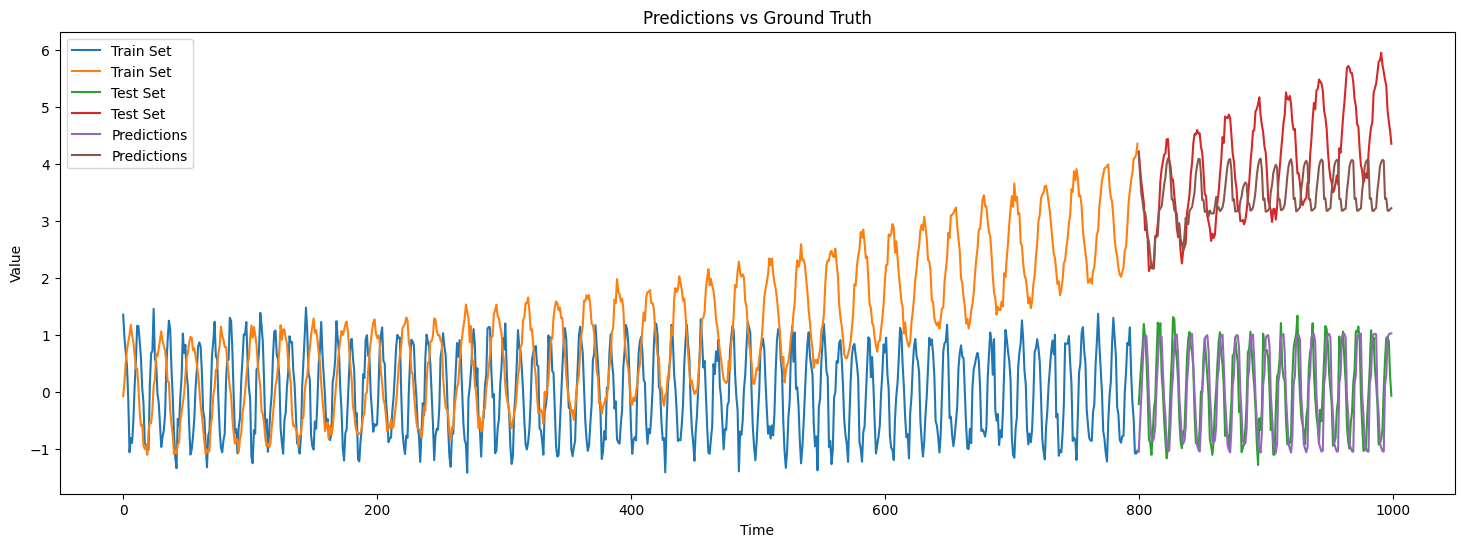

(     Feature      RMSE     RMSE %       MAE      MAE %       DTW       DTW %
 0      value  0.509118  19.444344  0.421492  16.097703  3.543668  135.340539
 1  aux_value  0.997498  26.034109  0.802949  20.956478  9.845338  256.957394,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

In [ ]:
# Define the model
model_rf = RandomForestRegressor(n_estimators=500, random_state=0)

sliding_window = 48
# Prepare train data
slide_train_df = pd.DataFrame()
for i in range(sliding_window+1):
    for column in train_df.columns:
        slide_train_df[f'{column}-{i}'] = train_scaled[column].shift(i)

slide_train_df.dropna(inplace=True)
slide_train_df_shuffled = slide_train_df.sample(frac=1, random_state=0)
slide_train_df_x = slide_train_df_shuffled.iloc[:,2:]
slide_train_df_y = slide_train_df_shuffled.iloc[:,:2]

# Fit the model
model_rf.fit(slide_train_df_x.values, slide_train_df_y.values)

# Generate predictions
test_inputs = slide_train_df.iloc[-1, 2:].values.reshape(1, -1)
prediction_rf = []
for i in range(len(test_df)):
    prediction = model_rf.predict(test_inputs)
    prediction_rf.append(prediction)
    test_inputs = np.roll(test_inputs, 2)
    test_inputs[0, :2] = prediction

prediction_rf = scaler.inverse_transform(np.array(prediction_rf).reshape(-1, 2))
plot_and_validate(train_df, test_df, prediction_rf)

### Long-Term Short-Term LSTM
Using LSTM (PyTorch) for forecasting.

In [ ]:
# Import the required libraries
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import random
from sklearn.metrics import mean_squared_error

In [ ]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.reset_hidden_cell()

    def reset_hidden_cell(self):
        self.hidden_cell = (torch.zeros(1,self.hidden_layer_size),
                            torch.zeros(1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.linear(lstm_out)

In [ ]:
# Prepare data for LSTM
train_data_normalized = torch.FloatTensor(train_scaled.values).view(-1, 2)

# Define a method to create in-out sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw-1]
        train_label = input_data[i+1:i+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
# Create in-out sequences
window_size = 12
train_inout_seq = create_inout_sequences(train_data_normalized, window_size)

# Initialize the model, define loss and optimization functions
model = LSTM(input_size=2, hidden_layer_size=50, output_size=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print ("--- Train ---")
# Train the model
epochs = 10 #100
steps = len(train_inout_seq)*epochs
bar = tqdm(total=steps)
print(f"Training steps: {steps}")
for i in range(epochs):
    #print(f"Start epoch {i}")
    epoch_loss = 0
    rmse = 0
    random.shuffle(train_inout_seq) # Randomize the training data

    for seq, labels in train_inout_seq:
        bar.update(1)
        #print("Forecasting seq")
        optimizer.zero_grad()
        model.reset_hidden_cell()
        y_pred = model(seq)
        #print("Get loss")
        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += single_loss/len(train_inout_seq)
            rmse += np.sqrt(mean_squared_error(scaler.inverse_transform(labels.detach().numpy()),
                                              scaler.inverse_transform(y_pred.squeeze().detach().numpy()))
                         )/len(train_inout_seq)

    print(f'Epoch {i} loss: {epoch_loss}. RMSE: {rmse}', end='\r')

--- Train ---


  0%|          | 0/7880 [00:00<?, ?it/s]

Training steps: 7880


  0%|          | 0/200 [00:00<?, ?it/s]

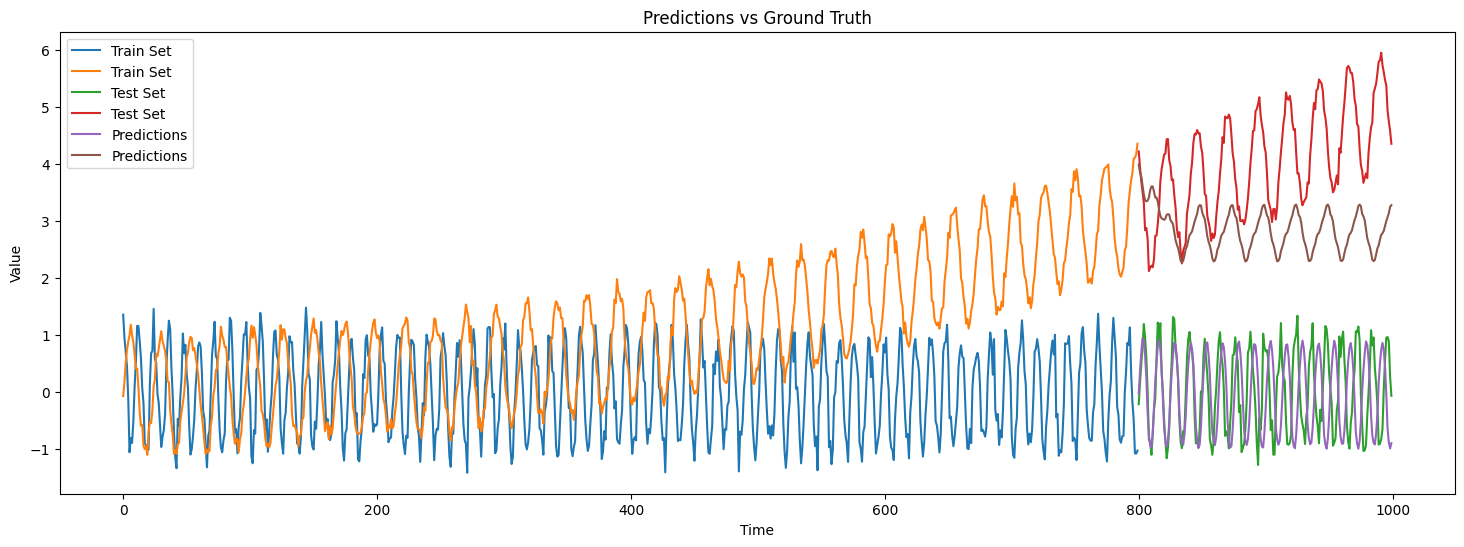

(     Feature      RMSE     RMSE %       MAE      MAE %        DTW       DTW %
 0      value  1.018950  38.915976  0.810650  30.960511   3.777283  144.262835
 1  aux_value  1.547773  40.395950  1.308534  34.151949  16.879117  440.534780,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>)

In [ ]:
# Evaluation
fut_pred = len(test_scaled)
test_inputs = train_data_normalized[-window_size:].tolist()
predictions = []
model.eval()
with torch.no_grad():
    model.reset_hidden_cell()
    seq = torch.FloatTensor(test_inputs[-window_size:])
    output = model(seq)[-1].unsqueeze(0)
    test_inputs.append(output.numpy())

    for i in tqdm(range(fut_pred)):
        output = model(output)
        test_inputs.append(output[-1].numpy())

# Invert transformations
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:]).reshape(-1, 2))

# Calculate RMSE for LSTM
plot_and_validate(train_df, test_df, actual_predictions)

## Transformer

You can check official tutorials at:
- [HuggingFace: Transformer for prediction](https://github.com/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb). A tutorial on how to use `Transformer`for time series prediction.



## Foundational Model

#### Moment
> 📜 MOMENT: A Family of Open Time-series Foundation Models 📜

> Follow & Adapt this tutorial
https://github.com/moment-timeseries-foundation-model/moment/blob/main/tutorials/forecasting.ipynb

In [ ]:
from momentfm import MOMENTPipeline
forecast_horizon = 50    # Horizonte de pronóstico
seq_len = 100

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-small",
    model_kwargs={
        "task_name": "forecasting",
        "seq_len": seq_len,            # Longitud del contexto (observado)
        "patch_len": 8,            # Valor típico en los modelos preentrenados
        "patch_stride_len": 8,     # Generalmente igual a patch_len
        "forecast_horizon": forecast_horizon,   # Horizonte de pronóstico, de modo que 600+200 = 800
        "head_dropout": 0.1,
        "weight_decay": 0,
        "freeze_encoder": True,
        "freeze_embedder": True,
        "freeze_head": False,      # El forecasting head se entrenará
    },
)
model.init()

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_df.shape

In [ ]:
from einops import rearrange

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

In [ ]:
from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

In [ ]:
from momentfm.utils.masking import Masking

In [ ]:
# --------------------------------------------------
# Parámetros
# --------------------------------------------------
batch_size = 8
max_epoch = 1

train_torch = torch.tensor(train_df.iloc[:, 0].values[:seq_len+forecast_horizon]).float()
valid_torch = torch.tensor(test_df.iloc[:, 0].values[:seq_len+forecast_horizon]).float()

# Creamos ventanas deslizantes que incluyan tanto el contexto como el horizonte.
# Cada ventana tendrá longitud: window_size + forecast_horizon.
# Resultado: tensor de forma [n_windows, 1, window_size + forecast_horizon]
train_windows = train_torch.unfold(0, seq_len+forecast_horizon, 1).unsqueeze(1)
valid_windows = valid_torch.unfold(0, seq_len+forecast_horizon, 1).unsqueeze(1)

# --------------------------------------------------
# Dataset que separa contexto (input) y objetivo (target)
# --------------------------------------------------
class ForecastingDataset(Dataset):
    def __init__(self, windows, context_size, forecast_horizon):
        """
        windows: tensor con forma [n_windows, 1, window_size + forecast_horizon]
        context_size: número de timesteps del contexto
        forecast_horizon: número de timesteps a pronosticar
        """
        self.windows = windows
        self.context_size = context_size
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return self.windows.size(0)

    def __getitem__(self, idx):
        window = self.windows[idx]  # [1, window_size + forecast_horizon]
        context = window[:, :self.context_size]    # [1, window_size]
        target = window[:, self.context_size:]       # [1, forecast_horizon]
        return context, target

# Crear los datasets y DataLoaders
train_dataset = ForecastingDataset(train_windows, seq_len, forecast_horizon)
valid_dataset = ForecastingDataset(valid_windows, seq_len, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# --------------------------------------------------
# Configuración de entrenamiento
# --------------------------------------------------
control_randomness(seed=13)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

# Usamos GradScaler para entrenamiento de precisión mixta (AMP)
scaler = torch.amp.GradScaler()
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=total_steps, pct_start=0.3)
max_norm = 5.0

# Nota: el modelo MOMENT espera entradas con forma [batch_size, n_channels, seq_len].
# Aquí, el contexto tendrá forma [batch_size, 1, window_size] y la máscara debe ser [batch_size, window_size].

cur_epoch = 0
while cur_epoch < max_epoch:
    losses = []
    model.train()  # Aseguramos que el modelo está en modo train
    for context, target in train_loader:
        # context: [batch_size, 1, window_size]
        # target: [batch_size, 1, forecast_horizon]
        context = context.to(device).float().requires_grad_()  # Forzamos requires_grad
        target = target.to(device).float()  # normalmente no es necesario que target requiera grad
        # Crear la máscara para el contexto con forma [batch_size, window_size]
        input_mask = torch.ones((context.shape[0], seq_len), device=device, dtype=torch.float32)
        input_mask.requires_grad_()  # Se fuerza para que tenga requires_grad

        # Usamos AMP con el nuevo API: el primer argumento es el device type
        with torch.amp.autocast(device.type, dtype=torch.float16 if device.type=='cuda' else torch.float32):
            output = model(x_enc=context, input_mask=input_mask, mask=input_mask)

        # Verificamos si se generó la forecast; si es None, saltamos este batch
        if output.forecast is None:
            print("Warning: output.forecast is None, saltando batch")
            continue

        predictions = output.forecast  # Se espera [batch_size, 1, forecast_horizon]
        loss = criterion(predictions, target)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    print(f"Epoch {cur_epoch}: Train loss: {np.average(losses):.3f}")
    scheduler.step()
    cur_epoch += 1

In [ ]:
print(test_df.shape)
print(train_df.shape)

#### Moirai
> 📜 Unified Training of Universal Time Series Forecasting Transformers 📜


> If you want to use moirai, you should follow & Adapt this tutorial https://github.com/SalesforceAIResearch/uni2ts/blob/main/example/moirai_forecast_pandas.ipynb

#### TimeGPT
> 📜 "TimeGPT-1: production ready pre-trained Time Series Foundation Model for forecasting and anomaly detection. Generative pretrained transformer for time series trained on over 100B data points. It's capable of accurately predicting various domains such as retail, electricity, finance, and IoT with just a few lines of code 🚀." 📜 - Nixtla

> If you want to use TimeGPT-1, you should follow & Adapt this tutorial https://github.com/Nixtla/nixtla?tab=readme-ov-file#forecast-using-timegpt-in-3-easy-steps

# Saving the notebook
**Download as pdf**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
nbs_path =  '/content/drive/MyDrive/SERTEMP-Collab'
nbs_name = '03_forecasting'

In [ ]:
! ls {nbs_path}/{nbs_name}.ipynb

/content/drive/MyDrive/SERTEMP-Collab/03_forecasting.ipynb


In [ ]:
from google.colab import files
!jupyter nbconvert --to PDF {nbs_path}/{nbs_name}.ipynb --output /{nbs_path}/{nbs_name}.pdf

[NbConvertApp] Converting notebook /content/drive/MyDrive/SERTEMP-Collab/03_forecasting.ipynb to PDF
/usr/local/share/jupyter/nbconvert/templates/latex/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  ((*- endblock -*))
[NbConvertApp] Support files will be in //content/drive/MyDrive/SERTEMP-Collab/03_forecasting_files/
[NbConvertApp] Writing 227470 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2712365 bytes to //content/drive/MyDrive/SERTEMP-Collab/03_forecasting.pdf


In [ ]:
files.download(f'{nbs_path}/{nbs_name}.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>